In [1]:
# add path to sispeuede to sys.path in python
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")


path_git = pathlib.Path("/Users/usuario/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    # "sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))

path_pipeline = path_git.joinpath("sisepuede_data_pipeline")


import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sisepuede.legacy.data_api as api
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.visualization.plots as spp
import sisepuede.utilities._plotting as spu
import sisepuede.core.support_classes as sc
import sisepuede.utilities._toolbox as sf
import time
from typing import *


import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib._util as lutil




##  Option to determine which columns are Peru specific - 20250807

In [4]:
repo_old = api.SISEPUEDEBatchDataRepository(
    "/Users/usuario/git/sisepuede_data", 
    matt,
)

In [ ]:
df_old = repo_old.read(None)

In [84]:
df_old_per = df_old[
    df_old["iso_code3"].isin(["PER"])
].drop(columns = ["iso_code3", "year"])

cols = [x for x in df_old_per.columns if df_old_per[x].dropna().shape[0] > 0]
cols_new = [x for x in df_from_pipeline.columns if x not in [regions.field_iso, time_periods.field_year]]
all_cols_peru = sorted(list(set(cols) | set(cols_new)))

# 
df_peru_fields_info = matt.build_variable_dataframe_by_sector(
    None,
    include_model_variable = True,
    include_model_variable_attributes = True,
    include_time_periods = False,
)
df_peru_fields_info["peru_specific_data_20250808"] = [
    1 if row["variable_field"] in all_cols_peru else 0 
    for i, row in df_peru_fields_info.iterrows()
]
df_peru_fields_info["input_variable"] = [
    1 if row["variable_field"] in matt.all_variable_fields_input else 0 
    for i, row in df_peru_fields_info.iterrows()
]


df_peru_fields_info.to_csv(
    "20250807_variable_information_table.csv",
    index = None,
    encoding = "UTF-8",
)


In [2]:
path_data_built = pathlib.Path(
    os.path.abspath("../generic_regions/data/output/sisepuede_raw_inputs_latest_PER.csv")
)

In [24]:
### SETUP DIRECTORIES

path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations_peru")


##  SETUP FILES

path_data_calib = path_data.joinpath("input_all_sectors_peru.csv")
path_data_base = path_data.joinpath("real_data_TZA_PER_LKA_20250210.csv")
#path_data_built = path_data.joinpath("sisepuede_raw_global_inputs_peru.csv")
path_data_built = pathlib.Path(
    os.path.abspath("../generic_regions/data/output/sisepuede_raw_inputs_latest_PER.csv")
)

##  SETUP SOME PIPELINE STUFF


file_struct = sfs.SISEPUEDEFileStructure()

# assign some shortcuts
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)


##  SOME GLOBALS

_REGION_NAME = "peru"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso", )


# Build transformations from completed raw file for 202506 model

In [4]:
df_peru = pd.read_csv(path_data_built)
df_peru[regions.key] = _REGION_NAME
df_peru = (
    df_peru[
        df_peru[time_periods.field_time_period].isin(
            time_periods.all_time_periods
        )
    ]
    .drop(
        columns = [time_periods.field_year, regions.field_iso], 
    )
    .reset_index(drop = True, )
)

In [5]:



examples = sxl.SISEPUEDEExamples()
df_examples = examples("input_data_frame").copy()

fields_missing = [x for x in df_examples.columns if x not in df_peru.columns]

df_peru = pd.merge(
    df_peru,
    df_examples[[time_periods.field_time_period] + fields_missing],
    how = "left",
)

df_peru["pop_lvst_initial_cattle_dairy"] = 800000
df_peru["pop_lvst_initial_cattle_nondairy"] = 4600000

In [6]:
df_peru_new = (
    pd.read_excel(
        "/Users/usuario/Downloads/source_data_frame_2025-08-26.xlsx", 
        skiprows = 7,
    )
)
df_peru_columns = (
    pd.read_excel(
        "/Users/usuario/Downloads/source_data_frame_2025-08-26.xlsx", 
        nrows = 0,
    )
    
)

df_peru_new.columns = df_peru_columns.columns
df_peru_new = df_peru_new.drop(columns = ["Fuente"])

fields_missing = [x for x in df_examples.columns if x not in df_peru_new.columns]
df_peru_new = pd.merge(
    df_peru_new,
    df_examples[[time_periods.field_time_period] + fields_missing],
    how = "left",
)

In [123]:
modvar_pop_init = matt.get_variable(model_afolu.modvar_lvst_pop_init)
modvar_pop_init.get_from_dataframe(df_peru_new).head()

,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
0,78,12328,788835,30969685,18894,3834,4942,5124,14200
1,78,12328,788835,30969685,18894,3834,4942,5124,14200
2,78,12328,788835,30969685,18894,3834,4942,5124,14200
3,62,11421,775607,30984631,18726,11486,4942,5124,14200
4,46,10515,762379,30999578,18559,19139,4942,5124,14200


In [125]:
modvar_pop_init = matt.get_variable(model_afolu.modvar_lvst_pop_init)
modvar_pop_init.get_from_dataframe(df_examples).head()



,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
0,78.0,12328.0,788835.0,30969685.0,18894.0,3834.0,4942.0,5124.0,14200.0
1,78.0,12328.0,788835.0,30969685.0,18894.0,3834.0,4942.0,5124.0,14200.0
2,78.0,12328.0,788835.0,30969685.0,18894.0,3834.0,4942.0,5124.0,14200.0
3,62.0,11421.0,775607.0,30984631.0,18726.0,11486.0,4942.0,5124.0,14200.0
4,46.0,10515.0,762379.0,30999578.0,18559.0,19139.0,4942.0,5124.0,14200.0


In [96]:
fields = [x for x in df_peru.columns if "lvst" in x and "entferm" in x]
df_peru[fields].head().astype(int)

modvar_pop = matt.get_variable(model_afolu.modvar_lvst_pop)
modvar_pop.get_from_dataframe(df_tmpd)



,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,78,12327,788834,30969684,18894,3833,4942,5123,14199
1,78,12423,790536,30637417,18936,3843,4953,5099,14289
2,78,12421,792348,30938127,18974,3850,4962,5133,14308
3,77,12349,794240,31478356,19016,3858,4974,5193,14271
4,78,12377,796024,31901358,19055,3866,4984,5263,14317
5,78,12370,797843,32308536,19103,3876,4996,5318,14354
6,78,12370,799656,32678360,19151,3886,5009,5370,14390
7,79,12368,801474,33059720,19198,3896,5022,5422,14425
8,78,12363,803301,33461406,19246,3905,5034,5476,14462
9,78,12355,805130,33881692,19296,3916,5047,5532,14499


In [128]:
df_out_orig[["emission_co2e_subsector_total_lvst"]]

,emission_co2e_subsector_total_lvst
0,12.498632
1,12.574924
2,12.789979
3,12.869748
4,12.953283
5,12.779251
6,12.725859
7,12.728518
8,12.675959
9,12.656110


In [127]:
import sisepuede.models.afolu as mafl
model_afolu = mafl.AFOLU(matt, )
df_out_orig = model_afolu(df_peru, )

In [108]:
df_out_orig[[x for x in df_out_orig.columns if "emission_co2e" in x and "lvst" in x]]
modvar_pop = matt.get_variable(model_afolu.modvar_lvst_pop)
modvar_pop.get_from_dataframe(df_out_orig)

,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,0,5553469,5553469,151000,1882041,743423,641172,3200713,11973039
1,0,5570291,5593020,152052,1896844,749251,646209,3246430,12067404
2,0,5658574,5689505,152670,1930069,762362,657524,3277902,12278902
3,0,5676863,5728529,153779,1944615,768087,662472,3328234,12371648
4,0,5707356,5764929,154298,1957344,773104,666805,3355127,12452735
5,0,5715095,5656868,150361,1913247,755746,651802,3216385,12171599
6,0,5583163,5681720,153198,1931550,762953,658030,3255321,12288261
7,0,5562757,5679713,153615,1932086,763161,658211,3263432,12291712
8,0,5542018,5648809,152976,1920911,758759,654408,3233685,12220493
9,0,5519096,5642411,153317,1919864,758343,654051,3238521,12213863


In [104]:
import sisepuede.models.afolu as mafl
model_afolu = mafl.AFOLU(matt, )
df_new = model_afolu(df_peru_new, )

In [105]:
df_new[[x for x in df_new.columns if "emission_co2e" in x and "lvst" in x]]


,emission_co2e_ch4_lvst_entferm_buffalo,emission_co2e_ch4_lvst_entferm_cattle_dairy,emission_co2e_ch4_lvst_entferm_cattle_nondairy,emission_co2e_ch4_lvst_entferm_chickens,emission_co2e_ch4_lvst_entferm_goats,emission_co2e_ch4_lvst_entferm_horses,emission_co2e_ch4_lvst_entferm_mules,emission_co2e_ch4_lvst_entferm_pigs,emission_co2e_ch4_lvst_entferm_sheep,emission_co2e_subsector_total_lvst
0,0.000142,0.028124,1.202195,0.0,0.003548,0.002057,0.001438,0.000179,0.002971,1.240654
1,0.000142,0.028343,1.204789,0.0,0.003556,0.002062,0.001441,0.000178,0.002990,1.243502
2,0.000142,0.028339,1.207551,0.0,0.003563,0.002066,0.001443,0.000179,0.002994,1.246277
3,0.000140,0.028175,1.210434,0.0,0.003571,0.002070,0.001447,0.000181,0.002987,1.249005
4,0.000142,0.028238,1.213153,0.0,0.003578,0.002074,0.001450,0.000184,0.002996,1.251816
5,0.000142,0.028222,1.215925,0.0,0.003587,0.002080,0.001453,0.000186,0.003004,1.254600
6,0.000142,0.028222,1.218688,0.0,0.003596,0.002085,0.001457,0.000188,0.003011,1.257390
7,0.000144,0.028218,1.221459,0.0,0.003605,0.002090,0.001461,0.000190,0.003019,1.260185
8,0.000142,0.028206,1.224243,0.0,0.003614,0.002095,0.001464,0.000191,0.003026,1.262983
9,0.000142,0.028188,1.227031,0.0,0.003623,0.002101,0.001468,0.000193,0.003034,1.265781


In [97]:
#df_peru.to_csv(path_data_built, encoding = "UTF-8", index = None, )




(56, 2419)

In [108]:
import sisepuede.transformers as trf

"""
transformers = trf.Transformers(
    {},
    df_input = df_peru,
)
"""
# initialize a transformations set
if not path_transformations.is_dir():
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )

transformations = trf.Transformations(
    path_transformations,
    df_input = df_peru,
)

transformers = transformations.transformers

strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)




"""attribute_strategy_new = sf._concat_df(
    [
        strategies.attribute_table.table,
        strategies.build_whirlpool_strategies(6002, )
    ]
)

attribute_strategy_new.to_csv(
    strategies.path_strategy_definition,
    encoding = "UTF-8",
    index = None
)""";

In [120]:
tab = strategies.attribute_table.table

# demonstrate A6
# strats_run = ["BASE", "PFLO:ALL"]
# strats_run += [x for x in list(tab[strategies.field_strategy_code]) if "AGRC:DEC_CH4_RICE" in x]
strats_run = [x for x in tab["strategy_code"].to_numpy() if x.startswith("PFLO:A6")]
strats_run += ["BASE", "PFLO:ALL", "PFLO:NDC_2020"]
strat_ids_a6 = sorted([strategies.get_strategy(x).id_num for x in strats_run])
strat_ids_a6



[0,
 6002,
 6003,
 6004,
 6005,
 6006,
 6007,
 6008,
 6009,
 6010,
 6011,
 6012,
 6013,
 6014,
 6015,
 6016,
 6017,
 6018,
 6019,
 6020,
 6021,
 6086,
 6087,
 6088,
 6089,
 6090,
 6091,
 6092,
 6093,
 6094,
 6095,
 6096,
 6097,
 6098,
 6099,
 6100,
 6101,
 6102,
 6103,
 6104,
 6105,
 6106,
 6107,
 6108,
 6109,
 6110,
 6111,
 6112,
 6113,
 6114,
 6115]

##  Phase 1 for transformations: run transformations one by one using defaults
- start by building all singletons to the templates to run

In [121]:

##  GET IN
strat_names = [
    x for x in strategies.attribute_table.table[strategies.field_strategy_name].to_numpy() 
    if x.startswith("Singleton")
]

# init
all_strategies_singleton = [strategies.baseline_id]

# add to list
for strat in strategies.all_strategies:
    nm = strategies.get_strategy(strat).name
    if nm in strat_names:
        all_strategies_singleton.append(strat)




# build templates--trajectory groups are not important right now
examples = sxl.SISEPUEDEExamples()
df_vargroups = examples("variable_trajectory_group_specification")
strategies.build_strategies_to_templates(
    #df_trajgroup = df_vargroups, 
    include_simplex_group_as_trajgroup = False,
    strategies = strat_ids_a6, # all_strategies_singleton,
)


0

##  20251020 - Build transformations for A6

In [96]:
#### transformations.all_transformation_codes

"""Rice management
Renewable energy
Industrial EE
Electrify LDV
Mode shift freight
Stop deforestation
Increase reforestation
Reduce enteric fermentation
Improve fertilizer application
Reduce HFCs"""

transformations_build = [
    "TX:AGRC:DEC_CH4_RICE",
    "TX:ENTC:TARGET_RENEWABLE_ELEC",
    "TX:INEN:INC_EFFICIENCY_ENERGY",
    "TX:TRNS:SHIFT_FUEL_LIGHT_DUTY",
    "TX:TRNS:SHIFT_MODE_FREIGHT",
    "TX:LNDU:DEC_DEFORESTATION",
    "TX:LNDU:INC_REFORESTATION",
    "TX:LVST:DEC_ENTERIC_FERMENTATION",
    "TX:SOIL:DEC_N_APPLIED",
    "TX:IPPU:DEC_HFCS"
]

##  INITIALIZE KEY ELEMENTS

# some basic vars
delim = "|"
codes = []
descriptions = []
ids = []
names = []
specs = []

#
id_num = max(strategies.attribute_table.key_values) + 1


# reference strategy and associated specifications
dict_strat_builds = {
    "PFLO:ALL": (1, 0), 
    "PFLO:NDC_2020": (1, 1),
}
dict_strat_pack = {}


#
strats_to_build = ["PFLO:ALL", "PFLO:NDC_2020"]
for code in strats_to_build:
    # get transformaion information
    strat_ref = strategies.get_strategy("PFLO:NDC_2020")
    all_transformations_ref = strat_ref.get_transformation_list(
        strat_ref.transformation_specification,
        transformations,
    )
    all_transformation_codes_ref = [x.code for x in all_transformations_ref]

    # add to dict
    tup = (strat_ref, all_transformations_ref, all_transformation_codes_ref, )
    dict_strat_pack.update({code: tup, })



# map transformer codes to all transformations
dict_transformer_code_to_transformations = transformations.get_transformation_codes_by_transformer_code()




##  ITERATE OVER TRANSFORMATIONS THAT NEED TO BE ADDED/REMOVED FROM BASE REF

for strat_build, strat_pack in dict_strat_pack.items():

    builds = dict_strat_builds.get(strat_build)
    (strat_ref, all_transformations_ref, all_transformation_codes_ref, ) = strat_pack

    
    for transformation_code in transformations_build:
    
        # check for transformations in NDC
        transformation = transformations.get_transformation(transformation_code)
        if transformation is None:
            raise RuntimeError(f"Transformation code {transformation_code} not found.")
    
    
        # get transformer and check for existing transformation in reference strategy with that code
        all_transformations_with_code = dict_transformer_code_to_transformations.get(
            transformation.transformer_code, 
        )
    
        tfmns_with_trfr_in_strat_ref = set(all_transformations_with_code) & set(all_transformation_codes_ref)
        if len(tfmns_with_trfr_in_strat_ref) == 0: continue
    
        # transformation to replace with current one (for 100%) and remove (for 0%)
        transformation_remove = list(tfmns_with_trfr_in_strat_ref)[0]
    
    
        ## build transformation WITH 100% implementation
        transformation_specification_0 = sorted([x for x in all_transformation_codes_ref if x != transformation_remove])
        transformation_specification_100 = sorted(transformation_specification_0 + [transformation_code])
        
        transformation_specification_0_str = delim.join(transformation_specification_0)
        transformation_specification_100_str = delim.join(transformation_specification_100)

        # build the 0?
        if builds[0] == 1:
            code = transformation_remove.replace(":", "")
            code = f"{strat_build}_NO_{code}"
            code = code.replace("PFLO:", "PFLO:A6_")
            name = f"A6 {strat_build} without {transformation_remove}"

            # append
            codes.append(code)
            descriptions.append(f"{name} for A6")
            ids.append(id_num)
            names.append(name)
            specs.append(transformation_specification_0_str)

            id_num += 1


        # build the 100?
        if builds[1] == 1:
            code = transformation_code.replace(":", "")
            code = f"{strat_build}_WITH_{code}"
            code = code.replace("PFLO:", "PFLO:A6_")
            name = f"A6 {strat_build} with {transformation_code}"

            # append
            codes.append(code)
            descriptions.append(f"{name} replacing {transformation_remove} for A6")
            ids.append(id_num)
            names.append(name)
            specs.append(transformation_specification_100_str)

            id_num += 1




df_additional_strategies = pd.DataFrame(
    {
        strategies.attribute_table.key: ids,
        strategies.field_baseline_strategy: np.zeros(len(specs)).astype(int),
        strategies.field_description: descriptions,
        strategies.field_strategy_code: codes,
        strategies.field_strategy_name: names,
        strategies.field_transformation_specification: specs,
    }
)




In [97]:
attr_strat_out = strategies.attribute_table.table
attr_strat_out = sf._concat_df(
    [
        attr_strat_out,
        df_additional_strategies[attr_strat_out.columns]
    ]
)

In [107]:
"""sf._write_csv(
    attr_strat_out,
    strategies.path_strategy_definition,
)"""

True

PosixPath('/Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/transformations_peru/strategy_definitions.csv')

In [57]:
dir(strat_ref)

strat_ref.get_transformation_list(
    strat_ref.transformation_specification,
    transformations,
)




['TX:AGRC:DEC_CH4_RICE_NDC2020_EST',
 'TX:AGRC:DEC_EXPORTS_NDC2020_EST',
 'TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_NDC2020_EST',
 'TX:AGRC:INC_CONSERVATION_AGRICULTURE_NDC2020_EST',
 'TX:AGRC:INC_PRODUCTIVITY_NDC2020_EST',
 'TX:CCSQ:INC_CAPTURE_NDC2020_EST',
 'TX:ENTC:DEC_LOSSES_NDC2020_EST',
 'TX:ENTC:TARGET_CLEAN_HYDROGEN_NDC2020_EST',
 'TX:ENTC:TARGET_RENEWABLE_ELEC_NDC2020_EST',
 'TX:FGTV:DEC_LEAKS_NDC2020_EST',
 'TX:FGTV:INC_FLARE_NDC2020_EST',
 'TX:INEN:INC_EFFICIENCY_ENERGY_NDC2020_EST',
 'TX:INEN:INC_EFFICIENCY_PRODUCTION_NDC2020_EST',
 'TX:INEN:SHIFT_FUEL_HEAT_NDC2020_EST',
 'TX:IPPU:DEC_CLINKER_NDC2020_EST',
 'TX:IPPU:DEC_DEMAND_NDC2020_EST',
 'TX:IPPU:DEC_HFCS_NDC2020_EST',
 'TX:IPPU:DEC_N2O_NDC2020_EST',
 'TX:IPPU:DEC_OTHER_FCS_NDC2020_EST',
 'TX:IPPU:DEC_PFCS_NDC2020_EST',
 'TX:LNDU:DEC_DEFORESTATION_NDC2020_EST',
 'TX:LNDU:DEC_SOC_LOSS_PASTURES_NDC2020_EST',
 'TX:LNDU:INC_REFORESTATION_NDC2020_EST',
 'TX:LNDU:INC_SILVOPASTURE_NDC2020_EST',
 'TX:LNDU:PLUR_NDC2020_EST',
 'TX:LSMM:I

# Next, build a SISEPUEDE object and load strategies

In [127]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    #id_str = ssp.id,
    initialize_as_dummy = False,
    regions = [_REGION_NAME],
    strategies = strategies,
    #try_exogenous_xl_types_in_variable_specification = True,
)





2025-10-20 12:52:17,723 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-10-20 12:52:17,723 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-10-20 12:52:17,725 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-10-20 12:52:17,725 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-10-20 12:52:17,726 - INFO - 	Setting export engine to 'csv'.
2025-10-20 12:52:17,726 - INFO - 	Setting export engine to 'csv'.
2025-10-20 12:52:17,726 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-10-20 12:52:17,726 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-10-20 12:52:17,727 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-10-20 12:52:17,727 - INFO - Successfully

## then, run the strategies one by one

In [128]:



dict_run = {
    ssp.key_future: [0],
    ssp.key_design: [0],
    ssp.key_strategy: strat_ids_a6,
}

# we'll save inputs since we're doing a small set of runs 
dict_successful = ssp(
    dict_run, 
    #force_overwrite_existing_primary_keys = True,
    save_inputs = True,
)

2025-10-20 12:52:58,983 - INFO - 
***	STARTING REGION peru	***

2025-10-20 12:52:58,983 - INFO - 
***	STARTING REGION peru	***

2025-10-20 12:53:00,804 - INFO - Trying run primary_id = 0 in region peru
2025-10-20 12:53:00,804 - INFO - Trying run primary_id = 0 in region peru
2025-10-20 12:53:00,806 - INFO - Running AFOLU model
2025-10-20 12:53:00,806 - INFO - Running AFOLU model
2025-10-20 12:53:01,054 - INFO - AFOLU model run successfully completed
2025-10-20 12:53:01,054 - INFO - AFOLU model run successfully completed
2025-10-20 12:53:01,055 - INFO - Running CircularEconomy model
2025-10-20 12:53:01,055 - INFO - Running CircularEconomy model
2025-10-20 12:53:01,086 - INFO - CircularEconomy model run successfully completed
2025-10-20 12:53:01,086 - INFO - CircularEconomy model run successfully completed
2025-10-20 12:53:01,086 - INFO - Running IPPU model
2025-10-20 12:53:01,086 - INFO - Running IPPU model
2025-10-20 12:53:01,130 - INFO - IPPU model run successfully completed
2025-10-2

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 12:58:20,077 - INFO - AFOLU model run successfully completed
2025-10-20 12:58:20,077 - INFO - AFOLU model run successfully completed
2025-10-20 12:58:20,078 - INFO - Running CircularEconomy model
2025-10-20 12:58:20,078 - INFO - Running CircularEconomy model
2025-10-20 12:58:20,106 - INFO - CircularEconomy model run successfully completed
2025-10-20 12:58:20,106 - INFO - CircularEconomy model run successfully completed
2025-10-20 12:58:20,107 - INFO - Running IPPU model
2025-10-20 12:58:20,107 - INFO - Running IPPU model
2025-10-20 12:58:20,147 - INFO - IPPU model run successfully completed
2025-10-20 12:58:20,147 - INFO - IPPU model run successfully completed
2025-10-20 12:58:20,147 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 12:58:20,147 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 12:58:20,158 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:04:15,769 - INFO - AFOLU model run successfully completed
2025-10-20 13:04:15,769 - INFO - AFOLU model run successfully completed
2025-10-20 13:04:15,769 - INFO - Running CircularEconomy model
2025-10-20 13:04:15,769 - INFO - Running CircularEconomy model
2025-10-20 13:04:15,795 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:04:15,795 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:04:15,796 - INFO - Running IPPU model
2025-10-20 13:04:15,796 - INFO - Running IPPU model
2025-10-20 13:04:15,838 - INFO - IPPU model run successfully completed
2025-10-20 13:04:15,838 - INFO - IPPU model run successfully completed
2025-10-20 13:04:15,838 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:04:15,838 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:04:15,850 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:05:56,111 - INFO - AFOLU model run successfully completed
2025-10-20 13:05:56,111 - INFO - AFOLU model run successfully completed
2025-10-20 13:05:56,112 - INFO - Running CircularEconomy model
2025-10-20 13:05:56,112 - INFO - Running CircularEconomy model
2025-10-20 13:05:56,137 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:05:56,137 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:05:56,137 - INFO - Running IPPU model
2025-10-20 13:05:56,137 - INFO - Running IPPU model
2025-10-20 13:05:56,177 - INFO - IPPU model run successfully completed
2025-10-20 13:05:56,177 - INFO - IPPU model run successfully completed
2025-10-20 13:05:56,177 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:05:56,177 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:05:56,188 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:07:35,925 - INFO - AFOLU model run successfully completed
2025-10-20 13:07:35,925 - INFO - AFOLU model run successfully completed
2025-10-20 13:07:35,925 - INFO - Running CircularEconomy model
2025-10-20 13:07:35,925 - INFO - Running CircularEconomy model
2025-10-20 13:07:35,949 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:07:35,949 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:07:35,950 - INFO - Running IPPU model
2025-10-20 13:07:35,950 - INFO - Running IPPU model
2025-10-20 13:07:35,989 - INFO - IPPU model run successfully completed
2025-10-20 13:07:35,989 - INFO - IPPU model run successfully completed
2025-10-20 13:07:35,989 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:07:35,989 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:07:35,999 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:09:15,508 - INFO - AFOLU model run successfully completed
2025-10-20 13:09:15,508 - INFO - AFOLU model run successfully completed
2025-10-20 13:09:15,509 - INFO - Running CircularEconomy model
2025-10-20 13:09:15,509 - INFO - Running CircularEconomy model
2025-10-20 13:09:15,534 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:09:15,534 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:09:15,535 - INFO - Running IPPU model
2025-10-20 13:09:15,535 - INFO - Running IPPU model
2025-10-20 13:09:15,576 - INFO - IPPU model run successfully completed
2025-10-20 13:09:15,576 - INFO - IPPU model run successfully completed
2025-10-20 13:09:15,577 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:09:15,577 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:09:15,587 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:10:55,036 - INFO - AFOLU model run successfully completed
2025-10-20 13:10:55,036 - INFO - AFOLU model run successfully completed
2025-10-20 13:10:55,037 - INFO - Running CircularEconomy model
2025-10-20 13:10:55,037 - INFO - Running CircularEconomy model
2025-10-20 13:10:55,061 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:10:55,061 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:10:55,062 - INFO - Running IPPU model
2025-10-20 13:10:55,062 - INFO - Running IPPU model
2025-10-20 13:10:55,102 - INFO - IPPU model run successfully completed
2025-10-20 13:10:55,102 - INFO - IPPU model run successfully completed
2025-10-20 13:10:55,102 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:10:55,102 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:10:55,112 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:12:35,151 - INFO - AFOLU model run successfully completed
2025-10-20 13:12:35,151 - INFO - AFOLU model run successfully completed
2025-10-20 13:12:35,151 - INFO - Running CircularEconomy model
2025-10-20 13:12:35,151 - INFO - Running CircularEconomy model
2025-10-20 13:12:35,175 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:12:35,175 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:12:35,176 - INFO - Running IPPU model
2025-10-20 13:12:35,176 - INFO - Running IPPU model
2025-10-20 13:12:35,216 - INFO - IPPU model run successfully completed
2025-10-20 13:12:35,216 - INFO - IPPU model run successfully completed
2025-10-20 13:12:35,216 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:12:35,216 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:12:35,227 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:16:49,964 - INFO - AFOLU model run successfully completed
2025-10-20 13:16:49,964 - INFO - AFOLU model run successfully completed
2025-10-20 13:16:49,964 - INFO - Running CircularEconomy model
2025-10-20 13:16:49,964 - INFO - Running CircularEconomy model
2025-10-20 13:16:49,989 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:16:49,989 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:16:49,989 - INFO - Running IPPU model
2025-10-20 13:16:49,989 - INFO - Running IPPU model
2025-10-20 13:16:50,029 - INFO - IPPU model run successfully completed
2025-10-20 13:16:50,029 - INFO - IPPU model run successfully completed
2025-10-20 13:16:50,030 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:16:50,030 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:16:50,040 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:23:05,168 - INFO - AFOLU model run successfully completed
2025-10-20 13:23:05,168 - INFO - AFOLU model run successfully completed
2025-10-20 13:23:05,168 - INFO - Running CircularEconomy model
2025-10-20 13:23:05,168 - INFO - Running CircularEconomy model
2025-10-20 13:23:05,193 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:23:05,193 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:23:05,193 - INFO - Running IPPU model
2025-10-20 13:23:05,193 - INFO - Running IPPU model
2025-10-20 13:23:05,233 - INFO - IPPU model run successfully completed
2025-10-20 13:23:05,233 - INFO - IPPU model run successfully completed
2025-10-20 13:23:05,233 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:23:05,233 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:23:05,243 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:24:47,237 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 13:24:47,237 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 13:24:47,576 - INFO - Table MODEL_INPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 13:24:47,576 - INFO - Table MODEL_INPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 13:24:47,584 - INFO - Trying run primary_id = 96096 i

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:26:27,772 - INFO - AFOLU model run successfully completed
2025-10-20 13:26:27,772 - INFO - AFOLU model run successfully completed
2025-10-20 13:26:27,772 - INFO - Running CircularEconomy model
2025-10-20 13:26:27,772 - INFO - Running CircularEconomy model
2025-10-20 13:26:27,796 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:26:27,796 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:26:27,797 - INFO - Running IPPU model
2025-10-20 13:26:27,797 - INFO - Running IPPU model
2025-10-20 13:26:27,836 - INFO - IPPU model run successfully completed
2025-10-20 13:26:27,836 - INFO - IPPU model run successfully completed
2025-10-20 13:26:27,837 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:26:27,837 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:26:27,847 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:29:24,889 - INFO - AFOLU model run successfully completed
2025-10-20 13:29:24,889 - INFO - AFOLU model run successfully completed
2025-10-20 13:29:24,890 - INFO - Running CircularEconomy model
2025-10-20 13:29:24,890 - INFO - Running CircularEconomy model
2025-10-20 13:29:24,915 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:29:24,915 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:29:24,915 - INFO - Running IPPU model
2025-10-20 13:29:24,915 - INFO - Running IPPU model
2025-10-20 13:29:24,955 - INFO - IPPU model run successfully completed
2025-10-20 13:29:24,955 - INFO - IPPU model run successfully completed
2025-10-20 13:29:24,956 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:29:24,956 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:29:24,966 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:32:24,439 - INFO - AFOLU model run successfully completed
2025-10-20 13:32:24,439 - INFO - AFOLU model run successfully completed
2025-10-20 13:32:24,440 - INFO - Running CircularEconomy model
2025-10-20 13:32:24,440 - INFO - Running CircularEconomy model
2025-10-20 13:32:24,464 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:32:24,464 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:32:24,465 - INFO - Running IPPU model
2025-10-20 13:32:24,465 - INFO - Running IPPU model
2025-10-20 13:32:24,505 - INFO - IPPU model run successfully completed
2025-10-20 13:32:24,505 - INFO - IPPU model run successfully completed
2025-10-20 13:32:24,505 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:32:24,505 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:32:24,515 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:35:20,504 - INFO - AFOLU model run successfully completed
2025-10-20 13:35:20,504 - INFO - AFOLU model run successfully completed
2025-10-20 13:35:20,505 - INFO - Running CircularEconomy model
2025-10-20 13:35:20,505 - INFO - Running CircularEconomy model
2025-10-20 13:35:20,530 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:35:20,530 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:35:20,530 - INFO - Running IPPU model
2025-10-20 13:35:20,530 - INFO - Running IPPU model
2025-10-20 13:35:20,570 - INFO - IPPU model run successfully completed
2025-10-20 13:35:20,570 - INFO - IPPU model run successfully completed
2025-10-20 13:35:20,571 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:35:20,571 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:35:20,581 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:38:14,615 - INFO - AFOLU model run successfully completed
2025-10-20 13:38:14,615 - INFO - AFOLU model run successfully completed
2025-10-20 13:38:14,616 - INFO - Running CircularEconomy model
2025-10-20 13:38:14,616 - INFO - Running CircularEconomy model
2025-10-20 13:38:14,641 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:38:14,641 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:38:14,641 - INFO - Running IPPU model
2025-10-20 13:38:14,641 - INFO - Running IPPU model
2025-10-20 13:38:14,683 - INFO - IPPU model run successfully completed
2025-10-20 13:38:14,683 - INFO - IPPU model run successfully completed
2025-10-20 13:38:14,683 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:38:14,683 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:38:14,694 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:41:05,562 - INFO - AFOLU model run successfully completed
2025-10-20 13:41:05,562 - INFO - AFOLU model run successfully completed
2025-10-20 13:41:05,562 - INFO - Running CircularEconomy model
2025-10-20 13:41:05,562 - INFO - Running CircularEconomy model
2025-10-20 13:41:05,586 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:41:05,586 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:41:05,587 - INFO - Running IPPU model
2025-10-20 13:41:05,587 - INFO - Running IPPU model
2025-10-20 13:41:05,626 - INFO - IPPU model run successfully completed
2025-10-20 13:41:05,626 - INFO - IPPU model run successfully completed
2025-10-20 13:41:05,627 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:41:05,627 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:41:05,637 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:43:56,445 - INFO - AFOLU model run successfully completed
2025-10-20 13:43:56,445 - INFO - AFOLU model run successfully completed
2025-10-20 13:43:56,445 - INFO - Running CircularEconomy model
2025-10-20 13:43:56,445 - INFO - Running CircularEconomy model
2025-10-20 13:43:56,469 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:43:56,469 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:43:56,469 - INFO - Running IPPU model
2025-10-20 13:43:56,469 - INFO - Running IPPU model
2025-10-20 13:43:56,508 - INFO - IPPU model run successfully completed
2025-10-20 13:43:56,508 - INFO - IPPU model run successfully completed
2025-10-20 13:43:56,509 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:43:56,509 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:43:56,519 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:46:53,959 - INFO - AFOLU model run successfully completed
2025-10-20 13:46:53,959 - INFO - AFOLU model run successfully completed
2025-10-20 13:46:53,960 - INFO - Running CircularEconomy model
2025-10-20 13:46:53,960 - INFO - Running CircularEconomy model
2025-10-20 13:46:53,984 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:46:53,984 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:46:53,985 - INFO - Running IPPU model
2025-10-20 13:46:53,985 - INFO - Running IPPU model
2025-10-20 13:46:54,025 - INFO - IPPU model run successfully completed
2025-10-20 13:46:54,025 - INFO - IPPU model run successfully completed
2025-10-20 13:46:54,025 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:46:54,025 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:46:54,036 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:49:52,472 - INFO - AFOLU model run successfully completed
2025-10-20 13:49:52,472 - INFO - AFOLU model run successfully completed
2025-10-20 13:49:52,473 - INFO - Running CircularEconomy model
2025-10-20 13:49:52,473 - INFO - Running CircularEconomy model
2025-10-20 13:49:52,499 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:49:52,499 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:49:52,499 - INFO - Running IPPU model
2025-10-20 13:49:52,499 - INFO - Running IPPU model
2025-10-20 13:49:52,544 - INFO - IPPU model run successfully completed
2025-10-20 13:49:52,544 - INFO - IPPU model run successfully completed
2025-10-20 13:49:52,545 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:49:52,545 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:49:52,557 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:52:46,923 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 13:52:46,923 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 13:52:47,326 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 13:52:47,326 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 13:52:47,336 - INFO - Trying run primary_id = 106

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:55:44,734 - INFO - AFOLU model run successfully completed
2025-10-20 13:55:44,734 - INFO - AFOLU model run successfully completed
2025-10-20 13:55:44,734 - INFO - Running CircularEconomy model
2025-10-20 13:55:44,734 - INFO - Running CircularEconomy model
2025-10-20 13:55:44,764 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:55:44,764 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:55:44,765 - INFO - Running IPPU model
2025-10-20 13:55:44,765 - INFO - Running IPPU model
2025-10-20 13:55:44,808 - INFO - IPPU model run successfully completed
2025-10-20 13:55:44,808 - INFO - IPPU model run successfully completed
2025-10-20 13:55:44,808 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:55:44,808 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:55:44,821 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 13:58:39,513 - INFO - AFOLU model run successfully completed
2025-10-20 13:58:39,513 - INFO - AFOLU model run successfully completed
2025-10-20 13:58:39,514 - INFO - Running CircularEconomy model
2025-10-20 13:58:39,514 - INFO - Running CircularEconomy model
2025-10-20 13:58:39,552 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:58:39,552 - INFO - CircularEconomy model run successfully completed
2025-10-20 13:58:39,553 - INFO - Running IPPU model
2025-10-20 13:58:39,553 - INFO - Running IPPU model
2025-10-20 13:58:39,596 - INFO - IPPU model run successfully completed
2025-10-20 13:58:39,596 - INFO - IPPU model run successfully completed
2025-10-20 13:58:39,597 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:58:39,597 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 13:58:39,608 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:04:59,038 - INFO - AFOLU model run successfully completed
2025-10-20 14:04:59,038 - INFO - AFOLU model run successfully completed
2025-10-20 14:04:59,038 - INFO - Running CircularEconomy model
2025-10-20 14:04:59,038 - INFO - Running CircularEconomy model
2025-10-20 14:04:59,067 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:04:59,067 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:04:59,068 - INFO - Running IPPU model
2025-10-20 14:04:59,068 - INFO - Running IPPU model
2025-10-20 14:04:59,110 - INFO - IPPU model run successfully completed
2025-10-20 14:04:59,110 - INFO - IPPU model run successfully completed
2025-10-20 14:04:59,111 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:04:59,111 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:04:59,124 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:07:59,006 - INFO - AFOLU model run successfully completed
2025-10-20 14:07:59,006 - INFO - AFOLU model run successfully completed
2025-10-20 14:07:59,007 - INFO - Running CircularEconomy model
2025-10-20 14:07:59,007 - INFO - Running CircularEconomy model
2025-10-20 14:07:59,031 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:07:59,031 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:07:59,031 - INFO - Running IPPU model
2025-10-20 14:07:59,031 - INFO - Running IPPU model
2025-10-20 14:07:59,071 - INFO - IPPU model run successfully completed
2025-10-20 14:07:59,071 - INFO - IPPU model run successfully completed
2025-10-20 14:07:59,072 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:07:59,072 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:07:59,082 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:11:31,392 - INFO - AFOLU model run successfully completed
2025-10-20 14:11:31,392 - INFO - AFOLU model run successfully completed
2025-10-20 14:11:31,392 - INFO - Running CircularEconomy model
2025-10-20 14:11:31,392 - INFO - Running CircularEconomy model
2025-10-20 14:11:31,420 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:11:31,420 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:11:31,421 - INFO - Running IPPU model
2025-10-20 14:11:31,421 - INFO - Running IPPU model
2025-10-20 14:11:31,460 - INFO - IPPU model run successfully completed
2025-10-20 14:11:31,460 - INFO - IPPU model run successfully completed
2025-10-20 14:11:31,461 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:11:31,461 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:11:31,471 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:16:27,917 - INFO - AFOLU model run successfully completed
2025-10-20 14:16:27,917 - INFO - AFOLU model run successfully completed
2025-10-20 14:16:27,918 - INFO - Running CircularEconomy model
2025-10-20 14:16:27,918 - INFO - Running CircularEconomy model
2025-10-20 14:16:27,942 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:16:27,942 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:16:27,943 - INFO - Running IPPU model
2025-10-20 14:16:27,943 - INFO - Running IPPU model
2025-10-20 14:16:27,983 - INFO - IPPU model run successfully completed
2025-10-20 14:16:27,983 - INFO - IPPU model run successfully completed
2025-10-20 14:16:27,983 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:16:27,983 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:16:27,994 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:20:29,932 - INFO - AFOLU model run successfully completed
2025-10-20 14:20:29,932 - INFO - AFOLU model run successfully completed
2025-10-20 14:20:29,933 - INFO - Running CircularEconomy model
2025-10-20 14:20:29,933 - INFO - Running CircularEconomy model
2025-10-20 14:20:29,957 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:20:29,957 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:20:29,958 - INFO - Running IPPU model
2025-10-20 14:20:29,958 - INFO - Running IPPU model
2025-10-20 14:20:29,998 - INFO - IPPU model run successfully completed
2025-10-20 14:20:29,998 - INFO - IPPU model run successfully completed
2025-10-20 14:20:29,998 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:20:29,998 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:20:30,009 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:25:05,781 - INFO - AFOLU model run successfully completed
2025-10-20 14:25:05,781 - INFO - AFOLU model run successfully completed
2025-10-20 14:25:05,782 - INFO - Running CircularEconomy model
2025-10-20 14:25:05,782 - INFO - Running CircularEconomy model
2025-10-20 14:25:05,806 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:25:05,806 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:25:05,807 - INFO - Running IPPU model
2025-10-20 14:25:05,807 - INFO - Running IPPU model
2025-10-20 14:25:05,846 - INFO - IPPU model run successfully completed
2025-10-20 14:25:05,846 - INFO - IPPU model run successfully completed
2025-10-20 14:25:05,847 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:25:05,847 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:25:05,857 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:27:58,917 - INFO - AFOLU model run successfully completed
2025-10-20 14:27:58,917 - INFO - AFOLU model run successfully completed
2025-10-20 14:27:58,918 - INFO - Running CircularEconomy model
2025-10-20 14:27:58,918 - INFO - Running CircularEconomy model
2025-10-20 14:27:58,943 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:27:58,943 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:27:58,943 - INFO - Running IPPU model
2025-10-20 14:27:58,943 - INFO - Running IPPU model
2025-10-20 14:27:58,983 - INFO - IPPU model run successfully completed
2025-10-20 14:27:58,983 - INFO - IPPU model run successfully completed
2025-10-20 14:27:58,984 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:27:58,984 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:27:58,994 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:30:53,847 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 14:30:53,847 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 14:30:54,247 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 14:30:54,247 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 14:30:54,259 - INFO - Trying run primary_id = 180

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:33:49,279 - INFO - AFOLU model run successfully completed
2025-10-20 14:33:49,279 - INFO - AFOLU model run successfully completed
2025-10-20 14:33:49,279 - INFO - Running CircularEconomy model
2025-10-20 14:33:49,279 - INFO - Running CircularEconomy model
2025-10-20 14:33:49,304 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:33:49,304 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:33:49,304 - INFO - Running IPPU model
2025-10-20 14:33:49,304 - INFO - Running IPPU model
2025-10-20 14:33:49,344 - INFO - IPPU model run successfully completed
2025-10-20 14:33:49,344 - INFO - IPPU model run successfully completed
2025-10-20 14:33:49,344 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:33:49,344 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:33:49,355 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:36:42,917 - INFO - AFOLU model run successfully completed
2025-10-20 14:36:42,917 - INFO - AFOLU model run successfully completed
2025-10-20 14:36:42,917 - INFO - Running CircularEconomy model
2025-10-20 14:36:42,917 - INFO - Running CircularEconomy model
2025-10-20 14:36:42,942 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:36:42,942 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:36:42,943 - INFO - Running IPPU model
2025-10-20 14:36:42,943 - INFO - Running IPPU model
2025-10-20 14:36:42,983 - INFO - IPPU model run successfully completed
2025-10-20 14:36:42,983 - INFO - IPPU model run successfully completed
2025-10-20 14:36:42,983 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:36:42,983 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:36:42,993 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:39:35,229 - INFO - AFOLU model run successfully completed
2025-10-20 14:39:35,229 - INFO - AFOLU model run successfully completed
2025-10-20 14:39:35,230 - INFO - Running CircularEconomy model
2025-10-20 14:39:35,230 - INFO - Running CircularEconomy model
2025-10-20 14:39:35,255 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:39:35,255 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:39:35,256 - INFO - Running IPPU model
2025-10-20 14:39:35,256 - INFO - Running IPPU model
2025-10-20 14:39:35,297 - INFO - IPPU model run successfully completed
2025-10-20 14:39:35,297 - INFO - IPPU model run successfully completed
2025-10-20 14:39:35,297 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:39:35,297 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:39:35,308 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:42:24,923 - INFO - AFOLU model run successfully completed
2025-10-20 14:42:24,923 - INFO - AFOLU model run successfully completed
2025-10-20 14:42:24,924 - INFO - Running CircularEconomy model
2025-10-20 14:42:24,924 - INFO - Running CircularEconomy model
2025-10-20 14:42:24,948 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:42:24,948 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:42:24,949 - INFO - Running IPPU model
2025-10-20 14:42:24,949 - INFO - Running IPPU model
2025-10-20 14:42:24,989 - INFO - IPPU model run successfully completed
2025-10-20 14:42:24,989 - INFO - IPPU model run successfully completed
2025-10-20 14:42:24,989 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:42:24,989 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:42:24,999 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:47:23,944 - INFO - AFOLU model run successfully completed
2025-10-20 14:47:23,944 - INFO - AFOLU model run successfully completed
2025-10-20 14:47:23,945 - INFO - Running CircularEconomy model
2025-10-20 14:47:23,945 - INFO - Running CircularEconomy model
2025-10-20 14:47:23,970 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:47:23,970 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:47:23,970 - INFO - Running IPPU model
2025-10-20 14:47:23,970 - INFO - Running IPPU model
2025-10-20 14:47:24,009 - INFO - IPPU model run successfully completed
2025-10-20 14:47:24,009 - INFO - IPPU model run successfully completed
2025-10-20 14:47:24,010 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:47:24,010 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:47:24,020 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:50:24,527 - INFO - AFOLU model run successfully completed
2025-10-20 14:50:24,527 - INFO - AFOLU model run successfully completed
2025-10-20 14:50:24,528 - INFO - Running CircularEconomy model
2025-10-20 14:50:24,528 - INFO - Running CircularEconomy model
2025-10-20 14:50:24,552 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:50:24,552 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:50:24,552 - INFO - Running IPPU model
2025-10-20 14:50:24,552 - INFO - Running IPPU model
2025-10-20 14:50:24,591 - INFO - IPPU model run successfully completed
2025-10-20 14:50:24,591 - INFO - IPPU model run successfully completed
2025-10-20 14:50:24,594 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:50:24,594 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:50:24,604 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:54:20,623 - INFO - AFOLU model run successfully completed
2025-10-20 14:54:20,623 - INFO - AFOLU model run successfully completed
2025-10-20 14:54:20,624 - INFO - Running CircularEconomy model
2025-10-20 14:54:20,624 - INFO - Running CircularEconomy model
2025-10-20 14:54:20,648 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:54:20,648 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:54:20,648 - INFO - Running IPPU model
2025-10-20 14:54:20,648 - INFO - Running IPPU model
2025-10-20 14:54:20,688 - INFO - IPPU model run successfully completed
2025-10-20 14:54:20,688 - INFO - IPPU model run successfully completed
2025-10-20 14:54:20,688 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:54:20,688 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:54:20,698 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 14:57:50,078 - INFO - AFOLU model run successfully completed
2025-10-20 14:57:50,078 - INFO - AFOLU model run successfully completed
2025-10-20 14:57:50,078 - INFO - Running CircularEconomy model
2025-10-20 14:57:50,078 - INFO - Running CircularEconomy model
2025-10-20 14:57:50,102 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:57:50,102 - INFO - CircularEconomy model run successfully completed
2025-10-20 14:57:50,103 - INFO - Running IPPU model
2025-10-20 14:57:50,103 - INFO - Running IPPU model
2025-10-20 14:57:50,143 - INFO - IPPU model run successfully completed
2025-10-20 14:57:50,143 - INFO - IPPU model run successfully completed
2025-10-20 14:57:50,143 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:57:50,143 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 14:57:50,154 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:06:30,557 - INFO - AFOLU model run successfully completed
2025-10-20 15:06:30,557 - INFO - AFOLU model run successfully completed
2025-10-20 15:06:30,558 - INFO - Running CircularEconomy model
2025-10-20 15:06:30,558 - INFO - Running CircularEconomy model
2025-10-20 15:06:30,582 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:06:30,582 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:06:30,583 - INFO - Running IPPU model
2025-10-20 15:06:30,583 - INFO - Running IPPU model
2025-10-20 15:06:30,622 - INFO - IPPU model run successfully completed
2025-10-20 15:06:30,622 - INFO - IPPU model run successfully completed
2025-10-20 15:06:30,622 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:06:30,622 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:06:30,633 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:15:38,563 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 15:15:38,563 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 15:15:38,955 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 15:15:38,955 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 15:15:38,965 - INFO - Trying run primary_id = 190

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:18:50,098 - INFO - AFOLU model run successfully completed
2025-10-20 15:18:50,098 - INFO - AFOLU model run successfully completed
2025-10-20 15:18:50,099 - INFO - Running CircularEconomy model
2025-10-20 15:18:50,099 - INFO - Running CircularEconomy model
2025-10-20 15:18:50,123 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:18:50,123 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:18:50,123 - INFO - Running IPPU model
2025-10-20 15:18:50,123 - INFO - Running IPPU model
2025-10-20 15:18:50,163 - INFO - IPPU model run successfully completed
2025-10-20 15:18:50,163 - INFO - IPPU model run successfully completed
2025-10-20 15:18:50,163 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:18:50,163 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:18:50,173 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:22:49,961 - INFO - AFOLU model run successfully completed
2025-10-20 15:22:49,961 - INFO - AFOLU model run successfully completed
2025-10-20 15:22:49,961 - INFO - Running CircularEconomy model
2025-10-20 15:22:49,961 - INFO - Running CircularEconomy model
2025-10-20 15:22:49,985 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:22:49,985 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:22:49,986 - INFO - Running IPPU model
2025-10-20 15:22:49,986 - INFO - Running IPPU model
2025-10-20 15:22:50,026 - INFO - IPPU model run successfully completed
2025-10-20 15:22:50,026 - INFO - IPPU model run successfully completed
2025-10-20 15:22:50,026 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:22:50,026 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:22:50,037 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:26:59,341 - INFO - AFOLU model run successfully completed
2025-10-20 15:26:59,341 - INFO - AFOLU model run successfully completed
2025-10-20 15:26:59,341 - INFO - Running CircularEconomy model
2025-10-20 15:26:59,341 - INFO - Running CircularEconomy model
2025-10-20 15:26:59,367 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:26:59,367 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:26:59,367 - INFO - Running IPPU model
2025-10-20 15:26:59,367 - INFO - Running IPPU model
2025-10-20 15:26:59,408 - INFO - IPPU model run successfully completed
2025-10-20 15:26:59,408 - INFO - IPPU model run successfully completed
2025-10-20 15:26:59,409 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:26:59,409 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:26:59,420 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:33:20,607 - INFO - AFOLU model run successfully completed
2025-10-20 15:33:20,607 - INFO - AFOLU model run successfully completed
2025-10-20 15:33:20,607 - INFO - Running CircularEconomy model
2025-10-20 15:33:20,607 - INFO - Running CircularEconomy model
2025-10-20 15:33:20,633 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:33:20,633 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:33:20,633 - INFO - Running IPPU model
2025-10-20 15:33:20,633 - INFO - Running IPPU model
2025-10-20 15:33:20,674 - INFO - IPPU model run successfully completed
2025-10-20 15:33:20,674 - INFO - IPPU model run successfully completed
2025-10-20 15:33:20,674 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:33:20,674 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:33:20,685 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:36:15,549 - INFO - AFOLU model run successfully completed
2025-10-20 15:36:15,549 - INFO - AFOLU model run successfully completed
2025-10-20 15:36:15,550 - INFO - Running CircularEconomy model
2025-10-20 15:36:15,550 - INFO - Running CircularEconomy model
2025-10-20 15:36:15,580 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:36:15,580 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:36:15,581 - INFO - Running IPPU model
2025-10-20 15:36:15,581 - INFO - Running IPPU model
2025-10-20 15:36:15,625 - INFO - IPPU model run successfully completed
2025-10-20 15:36:15,625 - INFO - IPPU model run successfully completed
2025-10-20 15:36:15,626 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:36:15,626 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:36:15,637 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:39:11,719 - INFO - AFOLU model run successfully completed
2025-10-20 15:39:11,719 - INFO - AFOLU model run successfully completed
2025-10-20 15:39:11,720 - INFO - Running CircularEconomy model
2025-10-20 15:39:11,720 - INFO - Running CircularEconomy model
2025-10-20 15:39:11,745 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:39:11,745 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:39:11,745 - INFO - Running IPPU model
2025-10-20 15:39:11,745 - INFO - Running IPPU model
2025-10-20 15:39:11,786 - INFO - IPPU model run successfully completed
2025-10-20 15:39:11,786 - INFO - IPPU model run successfully completed
2025-10-20 15:39:11,786 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:39:11,786 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:39:11,798 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:42:05,616 - INFO - AFOLU model run successfully completed
2025-10-20 15:42:05,616 - INFO - AFOLU model run successfully completed
2025-10-20 15:42:05,617 - INFO - Running CircularEconomy model
2025-10-20 15:42:05,617 - INFO - Running CircularEconomy model
2025-10-20 15:42:05,647 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:42:05,647 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:42:05,648 - INFO - Running IPPU model
2025-10-20 15:42:05,648 - INFO - Running IPPU model
2025-10-20 15:42:05,692 - INFO - IPPU model run successfully completed
2025-10-20 15:42:05,692 - INFO - IPPU model run successfully completed
2025-10-20 15:42:05,693 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:42:05,693 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:42:05,704 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:45:03,018 - INFO - AFOLU model run successfully completed
2025-10-20 15:45:03,018 - INFO - AFOLU model run successfully completed
2025-10-20 15:45:03,019 - INFO - Running CircularEconomy model
2025-10-20 15:45:03,019 - INFO - Running CircularEconomy model
2025-10-20 15:45:03,043 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:45:03,043 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:45:03,044 - INFO - Running IPPU model
2025-10-20 15:45:03,044 - INFO - Running IPPU model
2025-10-20 15:45:03,083 - INFO - IPPU model run successfully completed
2025-10-20 15:45:03,083 - INFO - IPPU model run successfully completed
2025-10-20 15:45:03,084 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:45:03,084 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:45:03,094 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:47:58,990 - INFO - AFOLU model run successfully completed
2025-10-20 15:47:58,990 - INFO - AFOLU model run successfully completed
2025-10-20 15:47:58,990 - INFO - Running CircularEconomy model
2025-10-20 15:47:58,990 - INFO - Running CircularEconomy model
2025-10-20 15:47:59,014 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:47:59,014 - INFO - CircularEconomy model run successfully completed
2025-10-20 15:47:59,015 - INFO - Running IPPU model
2025-10-20 15:47:59,015 - INFO - Running IPPU model
2025-10-20 15:47:59,054 - INFO - IPPU model run successfully completed
2025-10-20 15:47:59,054 - INFO - IPPU model run successfully completed
2025-10-20 15:47:59,055 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:47:59,055 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-10-20 15:47:59,065 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_eff

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:50:51,742 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 15:50:51,742 - INFO - Table MODEL_OUTPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_OUTPUT.csv.
2025-10-20 15:50:52,138 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 15:50:52,138 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 15:50:52,144 - INFO - Trying run primary_id = 200

set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


2025-10-20 15:53:46,120 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.
2025-10-20 15:53:46,120 - INFO - Table MODEL_INPUT successfully appended to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-10-20T12;52;16.991854/sisepuede_run_2025-10-20T12;52;16.991854_output_database/MODEL_INPUT.csv.


##  Read the outputs and inputs back in

In [129]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [132]:
ssp.generate_summary_files(None, export = True, );











In [133]:
df_long = pd.read_csv("/Users/usuario/Downloads/cb_data_long.csv")

In [139]:
df_out[
    df_out["primary_id"].isin([172172])
][[x for x in df_out.columns if x.startswith("emission_co2e_subsector_total")]]

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
792,2.129490,0.000000,26.267573,6.797791e+00,-150.533657,40.418018,95.264702,100.867763,0.611557,8.846022,5.070126,20.395174,42.629619,1.537322,2.792779
793,2.140891,0.000000,25.463847,6.212850e+00,-159.502675,37.903428,40.512369,114.236298,0.611088,8.827249,4.756759,21.553357,45.559624,1.583003,2.900195
794,2.258008,0.000000,23.695858,5.814279e+00,-162.162790,24.719761,12.762592,99.800976,0.620427,8.980040,4.507996,22.302482,47.384849,1.613573,2.971513
795,2.228850,0.000000,23.873069,5.732184e+00,-137.887764,49.802038,18.179476,85.239149,0.619887,8.954296,4.637718,22.797496,51.496040,1.662003,3.086296
796,2.193211,0.000000,23.267679,5.498265e+00,-177.574257,51.078847,18.017506,98.730225,0.620190,8.924382,4.680256,23.236431,53.396324,1.698366,3.154903
797,2.251364,0.000000,26.758361,7.633721e+00,-169.964126,136.931461,33.836273,98.459211,0.620939,8.960836,4.731891,23.822054,39.592531,1.565633,2.825525
798,2.268744,-0.539829,29.695924,8.086014e+00,-296.507164,126.059571,32.201555,98.274351,0.624046,8.962696,5.178002,24.288985,48.735167,1.710071,3.213725
799,2.261693,-1.079658,30.047020,7.959990e+00,-241.611057,119.011317,31.030844,98.618145,0.626776,8.987126,5.210881,24.578986,49.146627,1.736328,3.322647
800,2.238328,-1.619486,29.678197,7.828831e+00,-207.981380,114.139605,29.921456,98.982867,0.629286,9.021078,5.234601,24.716624,46.426283,1.721518,3.331625
801,2.253355,-2.159315,34.003998,8.680577e+00,-185.615628,109.725905,28.837370,99.572753,0.632634,9.057307,5.273482,24.693571,46.775125,1.745222,3.441420


(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

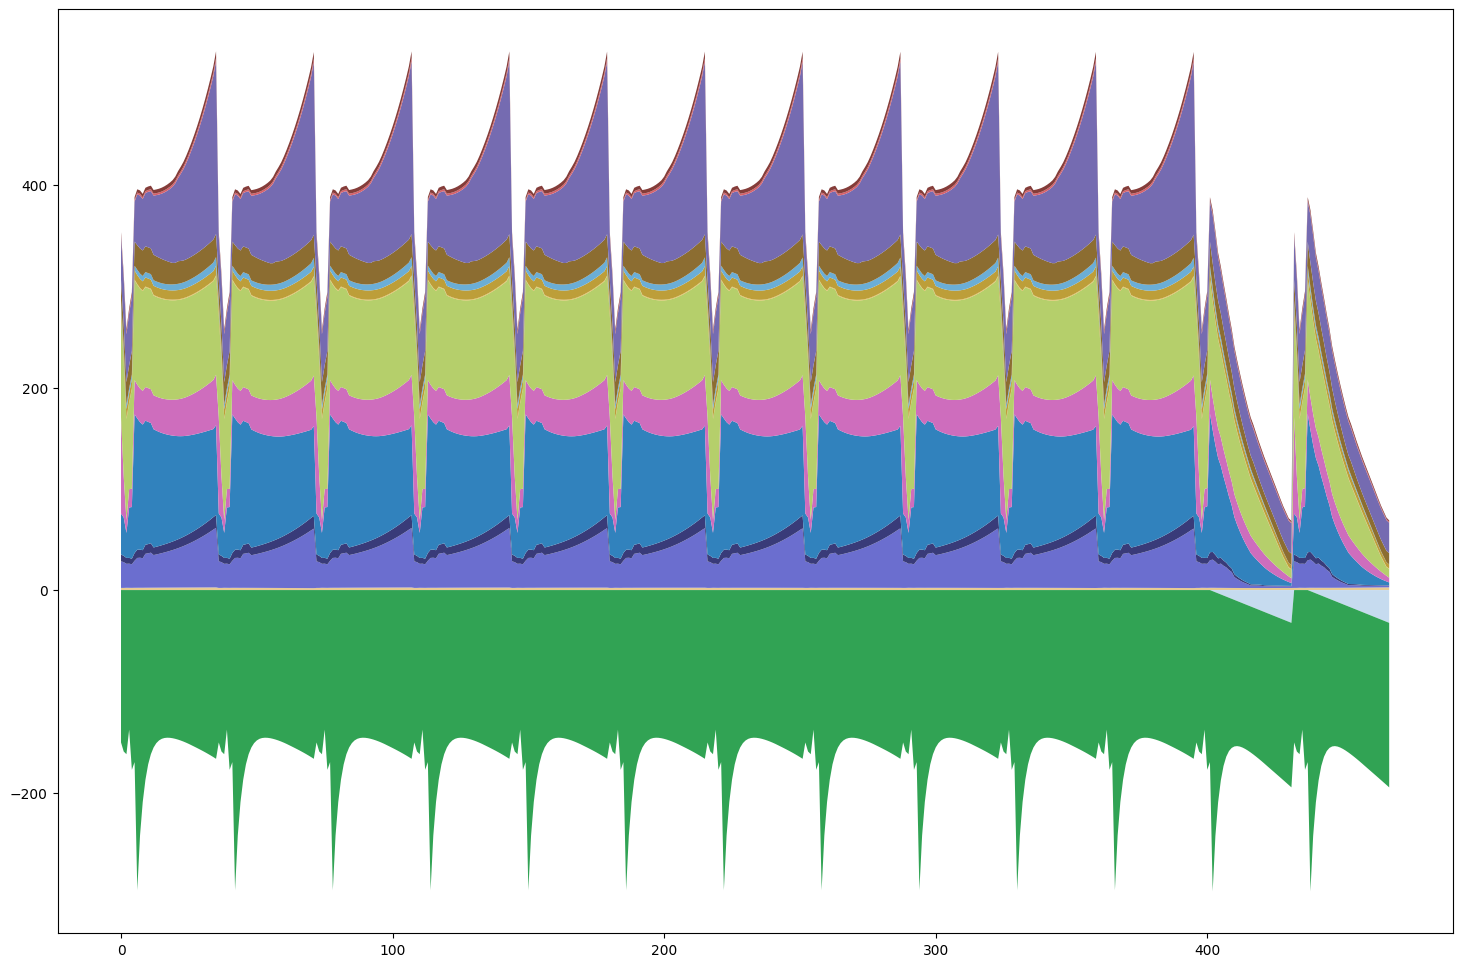

In [17]:
import sisepuede.visualization.plots as svp
svp.plot_emissions_stack(df_out, matt, )

In [45]:
# df_from_pipeline.columns

# Bulid Dataset for 202506 model with data we have

- Pull data fromo original repo (df_peru_base)
- Update with latest data (from new repo)
- Fill in values for new vars using `temp_update_fields_from_wv_to_main`
- Check if anything is missing

In [39]:
importlib.reload(dc)
construct = dc.SISEPUEDEDataConstructs(
    path_output_database = "/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite",
)

path_repo = pathlib.Path("/Users/usuario/SISEPUEDE_DATA_REPOSITORY")
repo = pu.Repository(
    {
        "local": {
            "path": str(path_repo)
        }
    }
)

In [66]:
import temp_update_fields_from_wv_to_main as temp 

examples = sxl.SISEPUEDEExamples()
df_example_input = examples("input_data_frame")

# get from original repo
df_peru_base = (
    pd.read_csv(path_data_base)
    .rename(
        columns = {
            "iso_code3": regions.field_iso,
            "Year": time_periods.field_year,
        }
    )
)

# get from pipeline
df_from_pipeline = construct.build_inputs_from_database(
    regions_keep = [_REGION_NAME],
)


# add in pipeline-based data
df_peru = sf.match_df_to_target_df(
    df_peru_base[
        df_peru_base[regions.field_iso].isin([_REGION_ISO])
    ],
    
    df_from_pipeline
    .drop(columns = [regions.field_iso]),
    
    [
        construct.time_periods.field_year,
    ],
    overwrite_only = False,
)

##  PULL FROM EXAMPLE DF

# fields not in peru
fields_missing = [
    x for x in df_example_input.columns 
    if (x not in df_peru.columns) 
    and (x in matt.all_variable_fields_input)
]

# specify fields to pull from the example
fields_from_ex = [
    x for x in fields_missing 
    if not (
        x.startswith("factor_lndu")
        or x.startswith("frac_lndu_")
    )
]

fields_from_ex = [
    x for x in fields_from_ex
    if (x not in df_peru.columns)
]

# merge in from ex
df_peru = pd.merge(
    df_peru,
    df_example_input[fields_from_ex + [time_periods.field_time_period]],
)


##  TEMPORARY SCRIPT FOR MOVING FROM working_version TO latest full version

df_peru = temp.update_fields(
    df_peru,
    matt,
)

# add in key
df_peru[regions.key] = _REGION_NAME


In [93]:
[x for x in dir(matt) if "get" in x and "emission" in x]

['get_all_subsector_emission_total_fields',
 'get_emission_subsectors',
 'get_sector_emission_total_fields',
 'get_subsector_emission_total_field']

# Try running to make sure it works and looks reasonable

In [39]:
models = sm.SISEPUEDEModels(
    matt,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)
df_run_enerprod = models(df_peru, include_electricity_in_energy = True, )

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1303.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


2025-30-Jun 12:20:12.448 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmptn7klt9h.sqlite.
2025-30-Jun 12:20:12.610 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmptn7klt9h.sqlite.
2025-30-Jun 12:20:20.073 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-30-Jun 12:21:02.761 Finished modeling scenario.


In [85]:
df_run = models(df_peru, include_electricity_in_energy = True, )

2025-06-Jun 12:26:46.217 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmpcloqz76s.sqlite.
2025-06-Jun 12:26:46.321 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmpcloqz76s.sqlite.
2025-06-Jun 12:26:56.975 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-06-Jun 12:27:28.961 Finished modeling scenario.


In [94]:
import sisepuede.plotting.plots as spp

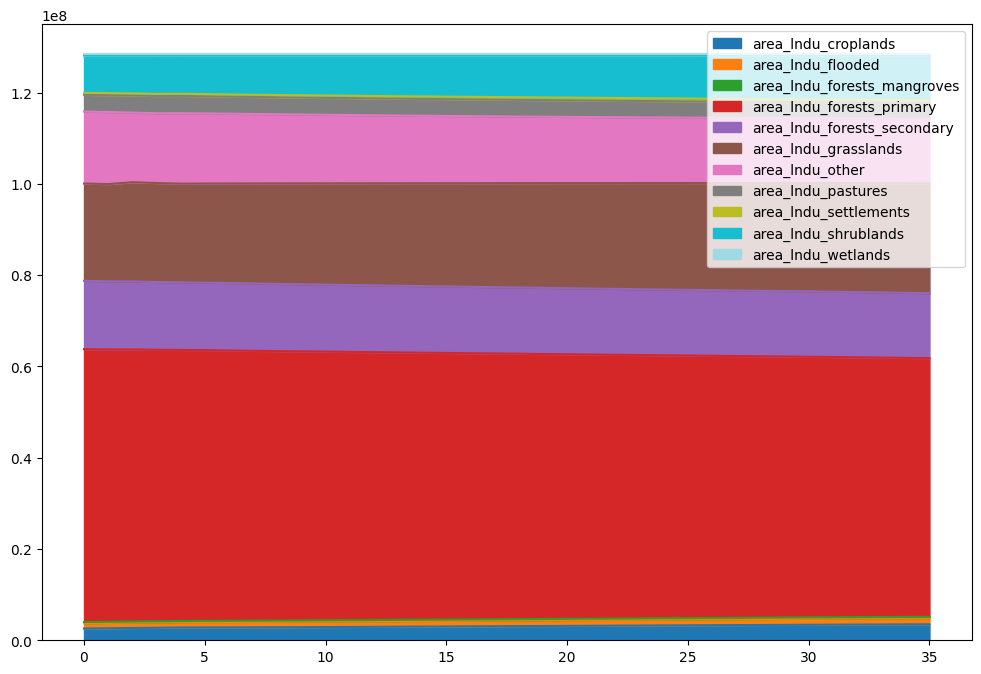

In [40]:
modvar = matt.get_variable("Land Use Area", )
fig, ax = plt.subplots(figsize = (12, 8))
df_run_enerprod[modvar.fields].plot.area(cmap = "tab20", ax = ax, )
ax.legend(loc = "upper right")


In [212]:
vals = matt.get_attribute_table("Liquid Waste").key_values
for k in vals:
    print(k)

ww_domestic_rural
ww_domestic_urban
ww_industrial


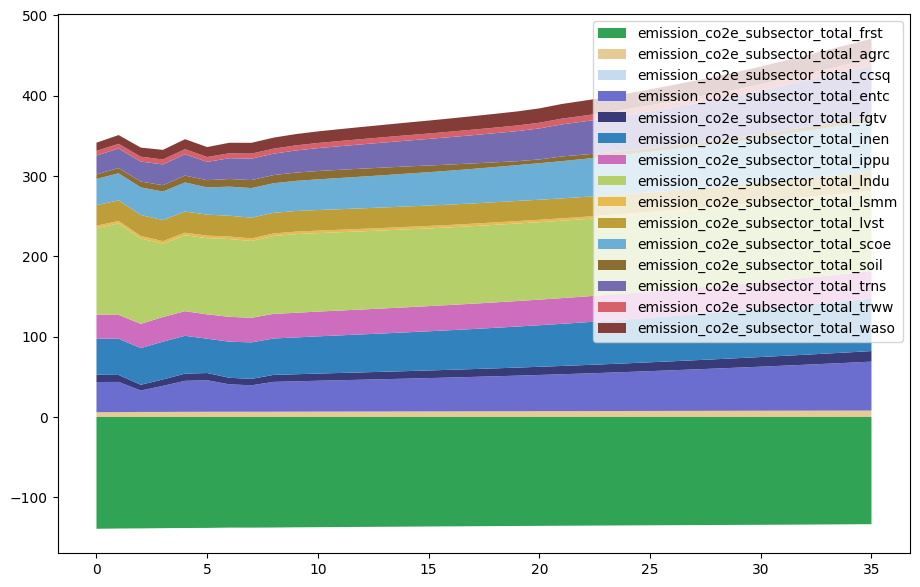

In [42]:
fig, ax = plt.subplots(figsize = (11, 7))
spp.plot_emissions_stack(
    df_run_enerprod,
    matt,
    figtuple = (fig, ax),
)

ax.legend()


# Skip here to run model

In [104]:
df_peru.to_csv(
    dir_data.joinpath("sisepuede_raw_global_inputs_peru.csv"),
    encoding = "UTF-8",
    index = None,
)

In [168]:
skip = 0


In [202]:
import sisepuede.transformers.transformers as trf2
importlib.reload(trf2)

transformers = trf2.Transformers(
    {},
    df_input = df_peru,
)



In [18]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)


df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

(
    ssp.model_attributes.get_dimensional_attribute_table(
        ssp.model_attributes.dim_time_period
    )
    .to_csv(
        os.path.join(dir_pkg, f"ATTRIBUTE_TIME_PERIOD.csv"),
    )
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [7]:
import sisepuede.models.afolu as mafl

In [19]:
dir_pkg

'/Users/usuario/git/sisepuede/sisepuede/out/sisepuede_summary_results_run_sisepuede_run_2025-10-08T12;55;48.005164'

In [71]:
df_afolu = pd.read_excel("/Users/usuario/Downloads/Var_SSP_AFOLU_2.xlsx")
df_afolu["time_period"] = range(36)

## ADJUST GENERATION FACTORS TO BE UNITLESS RATIOS

# get vars
modvar_gf_nitrogen = matt.get_variable("Daily Nitrogen Generation Factor")
modvar_gf_volsol = matt.get_variable("Daily Volatile Solid Generation Factor")
modvar_animal_weight = matt.get_variable("Animal Weight")

# get fields
cats_lvst = ["cattle_dairy", "cattle_nondairy"]
fields_aw = modvar_animal_weight.build_fields(category_restrictions = cats_lvst)
fields_n = modvar_gf_nitrogen.build_fields(category_restrictions = cats_lvst)
fields_vs = modvar_gf_volsol.build_fields(category_restrictions = cats_lvst)

# normalize by animal weight
arr_mass = df_peru[fields_aw].to_numpy()
arr_n_new = df_afolu[fields_n].to_numpy()/arr_mass
arr_vs_new = df_afolu[fields_vs].to_numpy()/arr_mass

# overwrite
df_afolu[fields_n] = arr_n_new
df_afolu[fields_vs] = arr_vs_new



df_peru_tmp = sf.match_df_to_target_df(
    df_peru,
    df_afolu[["time_period"] + [x for x in df_afolu.columns if ("lvst" in x) or ("lsmm" in x)]],
    ["time_period"],
    overwrite_only = True,
)




# get missing fields from example
examples = sxl.SISEPUEDEExamples()
df_example_input = examples("input_data_frame").copy()

# fields not in peru
fields_missing = [
    x for x in df_example_input.columns 
    if (x not in df_peru_tmp.columns) 
    and (x in matt.all_variable_fields_input)
]


# merge in from ex
df_peru_tmp = pd.merge(
    df_peru_tmp,
    df_example_input[fields_missing + [time_periods.field_time_period]],
)






df_tmp = model_afolu(df_peru_tmp, )

In [45]:
flds = [x for x in df_afolu.columns if ("lvst" in x) or ("lsmm" in x)]
df_afolu[flds].iloc[0]

ef_lsmm_direct_management_vacuno_methane_per_n          1.277143e+00
ef_lsmm_direct_management_others_methane_per_n          4.290000e-01
ef_lsmm_direct_management_system_methane_per_n          6.400000e-03
ef_lsmm_direct_management_vacuno_n_excretion_rate       2.341000e+00
ef_lvst_entferm_cattle_dairy_kg_ch4_head                1.118100e+02
ef_lvst_entferm_cattle_nondairy_kg_ch4_head             8.885873e+01
ef_lvst_entferm_goats_kg_ch4_head                       5.000000e+00
ef_lvst_entferm_horses_kg_ch4_head                      1.800000e+01
ef_lvst_entferm_mules_kg_ch4_head                       1.000000e+01
ef_lvst_entferm_pigs_kg_ch4_head                        1.000000e+00
ef_lvst_entferm_sheep_kg_ch4_head                       5.000000e+00
avgmass_lvst_animal_cattle_dairy_kg                     5.200000e+02
avgmass_lvst_animal_cattle_nondairy_kg                  3.065418e+02
genfactor_lvst_daily_nitrogen_cattle_dairy              1.731541e-01
genfactor_lvst_daily_nitrogen_catt

In [78]:
modvar = matt.get_variable("Livestock Head Count")

df_tmp[[x for x in df_tmp.columns if x.startswith("emission_co2e_subsector_total") and (("lsmm" in x) or ("lvst" in x))]]

,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst
0,0.963792,12.625403
1,0.978236,12.701419
2,0.996518,12.918906
3,1.004715,12.998187
4,1.012581,13.082043
5,0.998694,12.910400
6,0.983926,12.853457
7,0.987137,12.854637
8,0.982785,12.801472
9,0.981059,12.780671


In [89]:
# matt.get_attribute_table("Agriculture").key_values

In [90]:
# [x for x in df_afolu.columns if x not in matt.all_variable_fields_input]